## Notebook to test the vae model on smaller dataset

### load and sample the data

In [1]:

import sys

sys.path.append("../../")

import utils.load_csv as load_csv

set = load_csv.load_pandas()
set = load_csv.sample_data(set, 100)

# train and val only contain inliers and test contains both inliers and outliers
train, val, test = load_csv.split_data(set)
print(f"train length: {len(train)}")
print(f"val length: {len(val)}")
print(f"test length: {len(test)}")

print(f'outlier test training: {any(train["classification"] != 1)}')
print(f'outlier test validation: {any(val["classification"] != 1)}')
print(f'outlier test test: {any(test["classification"] != 1)}')
train

/home/bendm/machine_learning/project/majority-vote-outlier-detection/models/VAE/../../utils/load_csv.py:20: DtypeWarning: Columns (91,94,209,213) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(data_path, delimiter=";").iloc[:, -3:]


train length: 45
val length: 15
test length: 18
outlier test training: False
outlier test validation: False
outlier test test: True


,classification,file_names,label
2894,1,/home/bendm/machine_learning/project/majority-...,Singlet
2876,1,/home/bendm/machine_learning/project/majority-...,Singlet
4947,1,/home/bendm/machine_learning/project/majority-...,Singlet
5861,1,/home/bendm/machine_learning/project/majority-...,Singlet
2678,1,/home/bendm/machine_learning/project/majority-...,Singlet
7231,1,/home/bendm/machine_learning/project/majority-...,Singlet
9930,1,/home/bendm/machine_learning/project/majority-...,Singlet
971,1,/home/bendm/machine_learning/project/majority-...,Singlet
6340,1,/home/bendm/machine_learning/project/majority-...,Singlet
4640,1,/home/bendm/machine_learning/project/majority-...,Singlet


In [2]:
from models.VAE.VAE import VAE
from datetime import datetime

import torch
from torch.utils.tensorboard import SummaryWriter
from utils.dataloader import ImagePathDataset
from torchvision.transforms import v2

In [3]:
batch_size = 10
lr = 1e-3
weight_decay = 1e-2
epochs = 30
input_dim = 4800
hidden_dim = 4200
latent_dim = 525

transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((60, 80)),
        v2.ToTensor(),
        v2.Lambda(
            lambda x: (x.view(-1) - torch.min(x)) / (torch.max(x) - torch.min(x))
        ),
    ]
)

train_set = ImagePathDataset(train, transform=transform)
val_set = ImagePathDataset(val, transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True
)

/home/bendm/machine_learning/project/majority-vote-outlier-detection/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


tensor([[0.1013, 0.0949, 0.0994,  ..., 0.0972, 0.0944, 0.0922],
        [0.1126, 0.1336, 0.1668,  ..., 0.1209, 0.1262, 0.1314],
        [0.0719, 0.0645, 0.0643,  ..., 0.0736, 0.0702, 0.0687],
        ...,
        [0.0760, 0.0753, 0.0940,  ..., 0.0751, 0.0781, 0.0729],
        [0.0601, 0.0473, 0.0516,  ..., 0.0591, 0.0506, 0.0544],
        [0.0855, 0.0981, 0.1128,  ..., 0.0917, 0.0907, 0.0898]])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


/home/bendm/machine_learning/project/majority-vote-outlier-detection/.venv/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


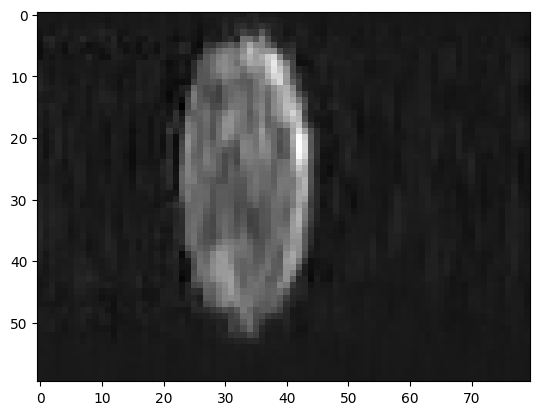

In [4]:
import matplotlib.pyplot as plt

for batch_idx, (data, target) in enumerate(train_dataloader):
    print(data)
    print(target)
    plt.imshow(data[0].resize(60,80), cmap="gray")
    break

reasonable output after all preprocessing transformations.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
writer = SummaryWriter(f'runs/outlier/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [6]:
prev_updates = 0
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    prev_updates = model.train_model(train_dataloader, optimizer, prev_updates, writer)
    model.test(val_dataloader, prev_updates, writer)

Epoch 1/30


  0%|          | 0/5 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 3887.3567 (Recon: 3326.9734, KL: 560.3833) Grad: 97.1270


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.19it/s]


====> Test set loss: 4809.3950 (BCE: 4422.5038, KLD: 386.8912)
Epoch 2/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.86it/s]


====> Test set loss: 2328.5515 (BCE: 2242.1617, KLD: 86.3898)
Epoch 3/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 16.61it/s]


====> Test set loss: 2197.0873 (BCE: 2148.5382, KLD: 48.5491)
Epoch 4/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 16.01it/s]


====> Test set loss: 2105.5139 (BCE: 2041.9235, KLD: 63.5903)
Epoch 5/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s]


====> Test set loss: 2068.6823 (BCE: 2049.6116, KLD: 19.0708)
Epoch 6/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s]


====> Test set loss: 2069.6389 (BCE: 2047.3499, KLD: 22.2891)
Epoch 7/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]


====> Test set loss: 2012.5707 (BCE: 2003.7133, KLD: 8.8574)
Epoch 8/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.13it/s]


====> Test set loss: 2072.4946 (BCE: 2048.4692, KLD: 24.0254)
Epoch 9/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.17it/s]


====> Test set loss: 2136.3840 (BCE: 2114.7557, KLD: 21.6283)
Epoch 10/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s]


====> Test set loss: 2128.6500 (BCE: 2111.3948, KLD: 17.2553)
Epoch 11/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]


====> Test set loss: 2063.9203 (BCE: 2035.0471, KLD: 28.8732)
Epoch 12/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.07it/s]


====> Test set loss: 2059.3744 (BCE: 2013.3299, KLD: 46.0445)
Epoch 13/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.46it/s]


====> Test set loss: 2026.1534 (BCE: 2017.9940, KLD: 8.1594)
Epoch 14/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s]


====> Test set loss: 2020.0024 (BCE: 2003.2858, KLD: 16.7167)
Epoch 15/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.70it/s]


====> Test set loss: 1987.8576 (BCE: 1976.8347, KLD: 11.0229)
Epoch 16/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


====> Test set loss: 2006.3208 (BCE: 1996.6559, KLD: 9.6649)
Epoch 17/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.38it/s]


====> Test set loss: 2233.1798 (BCE: 2226.8960, KLD: 6.2838)
Epoch 18/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.24it/s]


====> Test set loss: 2002.1956 (BCE: 1989.9919, KLD: 12.2037)
Epoch 19/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.81it/s]


====> Test set loss: 2110.0552 (BCE: 2105.0416, KLD: 5.0137)
Epoch 20/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.84it/s]


====> Test set loss: 2021.6918 (BCE: 2009.3045, KLD: 12.3873)
Epoch 21/30


  0%|          | 0/5 [00:00<?, ?it/s]

Step 100 (N samples: 1,000), Loss: 2109.1492 (Recon: 2091.1714, KL: 17.9778) Grad: 1012.9222


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.59it/s]


====> Test set loss: 2016.6041 (BCE: 2003.7511, KLD: 12.8529)
Epoch 22/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.26it/s]


====> Test set loss: 2016.6019 (BCE: 2005.9976, KLD: 10.6043)
Epoch 23/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 16.05it/s]


====> Test set loss: 2125.8386 (BCE: 2116.2692, KLD: 9.5695)
Epoch 24/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s]


====> Test set loss: 2072.7999 (BCE: 2060.6627, KLD: 12.1372)
Epoch 25/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.88it/s]


====> Test set loss: 2021.3945 (BCE: 2011.3321, KLD: 10.0624)
Epoch 26/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s]


====> Test set loss: 2013.6528 (BCE: 2010.7614, KLD: 2.8914)
Epoch 27/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 14.42it/s]


====> Test set loss: 1998.6485 (BCE: 1992.2631, KLD: 6.3853)
Epoch 28/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.90it/s]


====> Test set loss: 2066.9852 (BCE: 2056.7755, KLD: 10.2097)
Epoch 29/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s]


====> Test set loss: 2009.0841 (BCE: 2005.2062, KLD: 3.8778)
Epoch 30/30


Testing: 100%|██████████| 2/2 [00:00<00:00, 16.84it/s]

====> Test set loss: 2065.6469 (BCE: 2058.1545, KLD: 7.4924)
